# YouTubeで特定キーワードに関する動画を基礎分析してみた

- YouTube Data API v3 試してみた

## YouTube Data APIのAPI KEYを取得

- こちらにならう: https://qiita.com/ryoya41/items/dd1fd4c1427ece787eea

## 特定キーワードでYouTube動画リストを取得

In [497]:
from apiclient.discovery import build # $ pip install google-api-python-client
import datetime
import pandas as pd

# API KEYをセット
YOUTUBE_API_KEY = '【上で取得したAPI KEYをここに入力する】'

# 検索キーワード
query = 'プログラミング'

#1ページあたりに含める検索結果数。maxは50
maxResults = 50

#取得するページ数（累計取得動画数は、maxResults * max_pages）
max_pages = 50

In [498]:
# キーワードで動画検索関数
def search_videos(query, max_pages=10, maxResults=50):
    
    youtube = build(
        'youtube',
        'v3',
        developerKey = YOUTUBE_API_KEY
    )

    search_request = youtube.search().list(
        part='id',
        q=query,
        type='video',
        maxResults=maxResults,
    )

    i = 0
    while search_request and i < max_pages:
        search_response = search_request.execute()
        video_ids = [item['id']['videoId'] for item in search_response['items']]

        # 動画の詳細情報取得
        videos_response = youtube.videos().list(
            part='snippet,statistics',
            id=','.join(video_ids)
        ).execute()
        
        # 返却対象が無い場合は空配列を返却
        if len(videos_response['items']) == 0:
            print('search end!!')
            return []

        # 一旦動画情報を返却
        yield videos_response['items']

        search_request = youtube.search().list_next(search_request, search_response)
        i += 1

In [499]:
# 格納先のDataFrameを生成
df = pd.DataFrame(
    columns = ['id', 'url', 'publishedAt', 'channelId', 'title', 'timestamp',
               'viewCount','likeCount','dislikeCount','favoriteCount','commentCount'])
df

,id,url,publishedAt,channelId,title,timestamp,viewCount,likeCount,dislikeCount,favoriteCount,commentCount


In [500]:
#取得した動画情報から欲しい情報を取り出してリストに入れる
#今回はID、URL、投稿日時、投稿者のチャンネルID、動画タイトル、視聴回数、高評価数、低評価数、お気に入り回数を取得、またプログラム実行時刻も追加している
page_counter = 1
for items_per_page in search_videos(query, max_pages, maxResults):
    print('page:', page_counter)
    page_counter += 1
    
    for item in items_per_page:
        # ハッシュ作成
        obj = {}
        obj['id'] = item['id']
        obj['url'] = 'http://youtube.com/watch?v='+obj['id']
        snippet = item['snippet']
        for key in ['publishedAt','channelId','title']:
            obj[key] = snippet[key]
        statistics = item['statistics']
        for key in ['viewCount','likeCount','dislikeCount','favoriteCount','commentCount']:
            obj[key] = statistics[key] if key in statistics else "NA"
        obj['timestamp'] = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        
        # pandas格納
        df = df.append([obj])

page: 1
page: 2
page: 3
page: 4
page: 5
page: 6
page: 7
page: 8
page: 9
page: 10
page: 11
page: 12
search end!!


- クォータ制限（Googleによる利用制限）に引っかかりやすいので注意。
    - 403エラーでクォータ制限いわれたらそれ。
        - クォータの計算はここを参考に https://developers.google.com/youtube/v3/determine_quota_cost
    - GCPで別プロジェクト作ってAPI KEYを発行し直せば暫定的に制限回避できる。
    - クォータ制限はちゃんと申請すれば無料で上限引き上げられて、申請〜対応までに2週間くらいかかるみたい。
        - 参考: https://qiita.com/DevIwatan/items/e58d49b329cc981ab077

In [501]:
df.reset_index(drop=True, inplace=True)
df

,id,url,publishedAt,channelId,title,timestamp,viewCount,likeCount,dislikeCount,favoriteCount,commentCount
0,7VH-N-dsq3Y,http://youtube.com/watch?v=7VH-N-dsq3Y,2019-12-19T10:00:00Z,UCb9h8EpBlGHv9Z896fu4yeQ,【初心者向け】プログラミング学習の始め方【３ヶ月で達成できる】,2020-12-30 18:28:38,1032943,30898,657,0,1044
1,dD_KwXU9meA,http://youtube.com/watch?v=dD_KwXU9meA,2019-05-06T14:16:15Z,UCF2Kl5aL-_vcwaNhUf7YqbA,プログラミング講座 第１回【プログラミングとは】Akichon/あきちょん,2020-12-30 18:28:38,344589,5293,137,0,254
2,nhJaRJzotTk,http://youtube.com/watch?v=nhJaRJzotTk,2016-01-25T12:36:01Z,UCXjTiSGclQLVVU83GVrRM4w,堀江流！？プログラミング初心者におすすめの勉強方法,2020-12-30 18:28:38,328508,2512,163,0,170
3,DYX5yNk3HyM,http://youtube.com/watch?v=DYX5yNk3HyM,2019-03-20T22:00:02Z,UC67Wr_9pA4I0glIxDt_Cpyw,第3回 学長オススメのプログラミング勉強法【稼ぐ 実践編】,2020-12-30 18:28:38,237388,4270,69,0,75
4,xNvRpFcdcas,http://youtube.com/watch?v=xNvRpFcdcas,2020-10-20T10:18:34Z,UCb9h8EpBlGHv9Z896fu4yeQ,会社を辞めてプログラミング独学は、ありなのか【結論：なしです】,2020-12-30 18:28:38,75167,1684,68,0,122
...,...,...,...,...,...,...,...,...,...,...,...
573,q2Q0jElpGhs,http://youtube.com/watch?v=q2Q0jElpGhs,2020-12-26T16:33:13Z,UClRPOSBS_N4cnLPLjNvOJdw,世界最強のWebサービスを作ります【プログラミング放送】,2020-12-30 18:28:49,46,1,0,0,0
574,nVmj1JzCX7k,http://youtube.com/watch?v=nVmj1JzCX7k,2020-12-27T10:38:10Z,UC6QBR9a2qS_Fp5uorIY26pw,プログラミングアプリの Springin' というアプリを紹介！,2020-12-30 18:28:49,10,2,0,0,0
575,Wm8a1XzaNaE,http://youtube.com/watch?v=Wm8a1XzaNaE,2013-07-20T08:55:40Z,UCagC_BMaqYHikGIC6q-Ossg,パリの恋人（字幕版）,2020-12-30 18:28:49,NA,14,1,0,0
576,MRNu3fMts6g,http://youtube.com/watch?v=MRNu3fMts6g,2018-10-17T06:28:38Z,UCIjmSHkRzKlD-jQte0i8G8g,カンフー・トラベラー 南拳（字幕版）,2020-12-30 18:28:49,NA,NA,NA,0,NA


## 前処理

In [502]:
# 数値をint化
df[['viewCount','likeCount','dislikeCount','favoriteCount','commentCount']] = df[
    ['viewCount','likeCount','dislikeCount','favoriteCount','commentCount']
].applymap(lambda x: None if x=='NA' else int(x))

In [503]:
# publishedAtをdatetime化
df['publishedAt'] = df.publishedAt.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))

In [504]:
# いったん書き出しておく
df.to_csv("./output/%s_動画リスト.csv" % query)

In [505]:
df = pd.read_csv("./output/%s_動画リスト.csv" % query)

## 基礎集計

In [506]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='darkgrid')
sns.set(font="IPAexGothic")
%matplotlib inline

### 再生回数の多い動画

In [507]:
df.sort_values('viewCount', ascending=False)[:10][['title', 'viewCount', 'likeCount', 'dislikeCount', 'commentCount', 'url']]

,title,viewCount,likeCount,dislikeCount,commentCount,url
163,ゲームの世界にすいこまれた！？プログラミングであきらをたすけよう！,4496818.0,6931.0,1338.0,0.0,http://youtube.com/watch?v=NVXaCh7XPe8
275,本田圭佑がプログラミング教室「テックキャンプ」で学んだ理由 sponsored by 株式会...,4494962.0,117.0,16.0,7.0,http://youtube.com/watch?v=sVjEIyTOS04
433,2メートルのプログラミングいも虫ロボを作る。,4315037.0,32704.0,1187.0,4221.0,http://youtube.com/watch?v=zNLhC_dRlY8
314,スライムぷよぷよゼリー！いろんなプールで演奏してみた♪ MakeyMakey,3639435.0,8337.0,1103.0,0.0,http://youtube.com/watch?v=sD55eyMcQGQ
35,【堀江貴文×マコなり社長】プログラミングは超絶簡単,1972672.0,14895.0,571.0,885.0,http://youtube.com/watch?v=g2AFcjHPO2A
53,プログラミングは超絶カンタン!? 話題になった「堀江貴文×マコなり社長」対談をお届けします,1667851.0,3606.0,4461.0,347.0,http://youtube.com/watch?v=TKOpLMcXGAk
432,2ちゃんねる創設者ひろゆきがプログラミングを始めた理由とは？sponsored by 株式会...,1496420.0,57.0,4.0,6.0,http://youtube.com/watch?v=nWP9T-2iEYY
319,ジュースを飲んだら不思議なことが！プログラミングでママをたすけよう！,1418167.0,4160.0,432.0,557.0,http://youtube.com/watch?v=gExCWsP2GiU
14,パズドラを小一時間で作ってみた【プログラミング実況】Programming Match-Th...,1066314.0,16220.0,725.0,1498.0,http://youtube.com/watch?v=JLQLxrgygKk
0,【初心者向け】プログラミング学習の始め方【３ヶ月で達成できる】,1032943.0,30898.0,657.0,1044.0,http://youtube.com/watch?v=7VH-N-dsq3Y


### いいね数が多い動画

In [508]:
df.sort_values('likeCount', ascending=False)[:10][['title', 'viewCount', 'likeCount', 'dislikeCount', 'commentCount', 'url']]

,title,viewCount,likeCount,dislikeCount,commentCount,url
433,2メートルのプログラミングいも虫ロボを作る。,4315037.0,32704.0,1187.0,4221.0,http://youtube.com/watch?v=zNLhC_dRlY8
0,【初心者向け】プログラミング学習の始め方【３ヶ月で達成できる】,1032943.0,30898.0,657.0,1044.0,http://youtube.com/watch?v=7VH-N-dsq3Y
8,プログラミングにはやってはいけない勉強法がある！？爆速で成長する王道のプログラミング学習法を紹介！,653934.0,19064.0,751.0,819.0,http://youtube.com/watch?v=ZJqVQJwvwNI
60,プログラミングで「月5万円」を稼ぐために必要な学習時間を解説する,604566.0,18261.0,359.0,527.0,http://youtube.com/watch?v=IbFrSb5YaTQ
14,パズドラを小一時間で作ってみた【プログラミング実況】Programming Match-Th...,1066314.0,16220.0,725.0,1498.0,http://youtube.com/watch?v=JLQLxrgygKk
35,【堀江貴文×マコなり社長】プログラミングは超絶簡単,1972672.0,14895.0,571.0,885.0,http://youtube.com/watch?v=g2AFcjHPO2A
34,大学生がプログラミングを学べば、アルバイトよりも稼げます【方法論の解説】,493245.0,14687.0,501.0,1126.0,http://youtube.com/watch?v=NWWGoh417Jk
19,Python超入門コース 合併版｜Pythonの超基本的な部分をたった1時間で学べます【プロ...,525840.0,9800.0,170.0,395.0,http://youtube.com/watch?v=HyU3XL2F9GE
94,【裏話】本田圭佑さんが本気でプログラミング学んだときの話,439886.0,8879.0,200.0,333.0,http://youtube.com/watch?v=ZcJ_hYLVaUY
314,スライムぷよぷよゼリー！いろんなプールで演奏してみた♪ MakeyMakey,3639435.0,8337.0,1103.0,0.0,http://youtube.com/watch?v=sD55eyMcQGQ


### いいね比率が高い動画

In [509]:
df.assign(likeRatio = df['likeCount'] / (df['likeCount'] + df['dislikeCount'])).\
    sort_values(by=['likeRatio', 'likeCount'], ascending=False)[:10][['title', 'likeRatio', 'viewCount', 'likeCount', 'dislikeCount', 'commentCount', 'url']]

,title,likeRatio,viewCount,likeCount,dislikeCount,commentCount,url
274,プログラミングをやってみよう【Unity初心者入門講座】【ゲームの作り方】#13,1.0,17254.0,291.0,0.0,56.0,http://youtube.com/watch?v=SwI3duEdcCA
510,【競技プログラミング】ABC186【ゆっくり実況】,1.0,2446.0,103.0,0.0,3.0,http://youtube.com/watch?v=su1QrfVkZK4
143,【初心者必見！】プログラミング学習でやってはいけない3つのこと,1.0,3879.0,102.0,0.0,6.0,http://youtube.com/watch?v=YJnD6OsuzbQ
283,【大注目！】初心者におすすめのプログラミング言語4選！学ぶべき言語を紹介,1.0,4437.0,96.0,0.0,1.0,http://youtube.com/watch?v=dMCKuCtaq9I
231,【Windows】プログラミングのための Windows入門,1.0,3046.0,79.0,0.0,5.0,http://youtube.com/watch?v=kSqY9PG1Qa8
308,【パワーストーン】(クリスタルとかミネラルとか)とプログラミング(御霊入れ)について,1.0,1222.0,46.0,0.0,0.0,http://youtube.com/watch?v=oSo3_LLCkrA
506,【楽しく学べる！】プログラミングをゲーム感覚で学べるサービス6選,1.0,892.0,40.0,0.0,2.0,http://youtube.com/watch?v=__g7Gk_Bd_4
525,プログラミング入門2021,1.0,713.0,32.0,0.0,4.0,http://youtube.com/watch?v=FVhB9FpMNv4
365,BMWのキープログラミング完成まであともうちょっと！,1.0,795.0,30.0,0.0,7.0,http://youtube.com/watch?v=ggOc00934KY
170,【聞き流し/作業用】 聞き流しリファレンス HTMLタグ編 part 1【プログラミング】,1.0,820.0,29.0,0.0,6.0,http://youtube.com/watch?v=42xAdILMz2o


### コメント数が多い動画

In [510]:
df.sort_values('commentCount', ascending=False)[:10][['title', 'viewCount', 'likeCount', 'dislikeCount', 'commentCount', 'url']]

,title,viewCount,likeCount,dislikeCount,commentCount,url
433,2メートルのプログラミングいも虫ロボを作る。,4315037.0,32704.0,1187.0,4221.0,http://youtube.com/watch?v=zNLhC_dRlY8
14,パズドラを小一時間で作ってみた【プログラミング実況】Programming Match-Th...,1066314.0,16220.0,725.0,1498.0,http://youtube.com/watch?v=JLQLxrgygKk
34,大学生がプログラミングを学べば、アルバイトよりも稼げます【方法論の解説】,493245.0,14687.0,501.0,1126.0,http://youtube.com/watch?v=NWWGoh417Jk
0,【初心者向け】プログラミング学習の始め方【３ヶ月で達成できる】,1032943.0,30898.0,657.0,1044.0,http://youtube.com/watch?v=7VH-N-dsq3Y
342,建設業＞＞ＩＴ（プログラミングスクールｗｗｗ）である理由を語る,87837.0,1830.0,109.0,962.0,http://youtube.com/watch?v=YUZ01WC9biU
35,【堀江貴文×マコなり社長】プログラミングは超絶簡単,1972672.0,14895.0,571.0,885.0,http://youtube.com/watch?v=g2AFcjHPO2A
8,プログラミングにはやってはいけない勉強法がある！？爆速で成長する王道のプログラミング学習法を紹介！,653934.0,19064.0,751.0,819.0,http://youtube.com/watch?v=ZJqVQJwvwNI
24,理想と現実のプログラミング,541004.0,7115.0,173.0,789.0,http://youtube.com/watch?v=5HBz3rQOqXU
215,プログラミングスクールのイベントを開催します!!!【いぬたぬき】,37410.0,1862.0,21.0,598.0,http://youtube.com/watch?v=XplmncvZw1o
319,ジュースを飲んだら不思議なことが！プログラミングでママをたすけよう！,1418167.0,4160.0,432.0,557.0,http://youtube.com/watch?v=gExCWsP2GiU


### チャンネルあたりの動画数

Text(0.5, 1.0, 'チャンネルあたりの動画数')

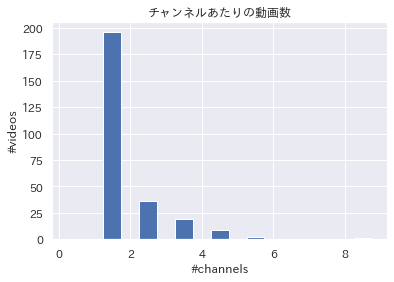

In [511]:
df.groupby('channelId').size().sort_values(ascending=False).hist(bins=range(0,10,1), rwidth=0.5)
plt.xlabel('#channels')
plt.ylabel('#videos')
plt.title('チャンネルあたりの動画数')

### 動画の閲覧数分布

Text(0.5, 1.0, '動画の閲覧数分布（x軸対数）')

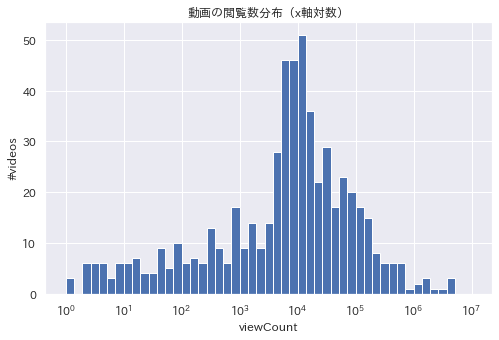

In [512]:
ax=plt.figure(figsize=(8,5)).add_subplot(111)
df.viewCount.dropna().sort_values(ascending=False).hist(bins=np.logspace(0,7,50))
ax.set_xscale('log')
ax.set_xlabel('viewCount')
ax.set_ylabel('#videos')
ax.set_title('動画の閲覧数分布（x軸対数）')

### 動画のいいね数分布

Text(0.5, 1.0, '動画のいいね数分布（x軸対数）')

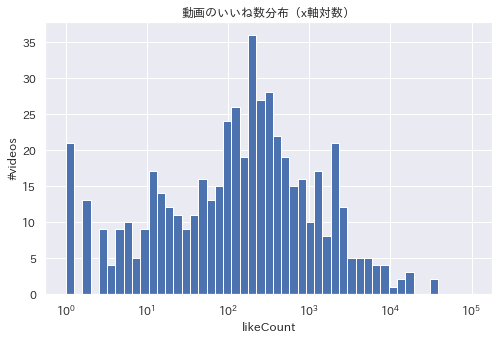

In [513]:
ax=plt.figure(figsize=(8,5)).add_subplot(111)
df.likeCount.dropna().sort_values(ascending=False).hist(bins=np.logspace(0,5,50))
ax.set_xscale('log')
ax.set_xlabel('likeCount')
ax.set_ylabel('#videos')
ax.set_title('動画のいいね数分布（x軸対数）')

### 動画のよくないね数分布

Text(0.5, 1.0, '動画のよくないね数分布（x軸対数）')

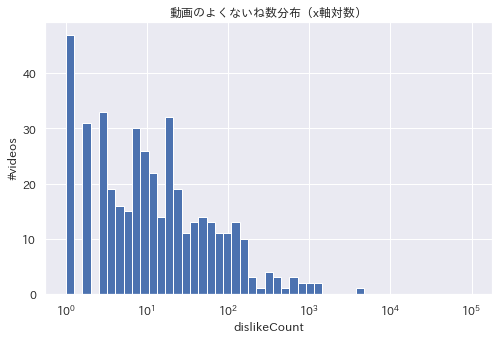

In [514]:
ax=plt.figure(figsize=(8,5)).add_subplot(111)
df.dislikeCount.dropna().sort_values(ascending=False).hist(bins=np.logspace(0,5,50))
ax.set_xscale('log')
ax.set_xlabel('dislikeCount')
ax.set_ylabel('#videos')
ax.set_title('動画のよくないね数分布（x軸対数）')

### 動画のコメント数分布

Text(0.5, 1.0, '動画のコメント数分布（x軸対数）')

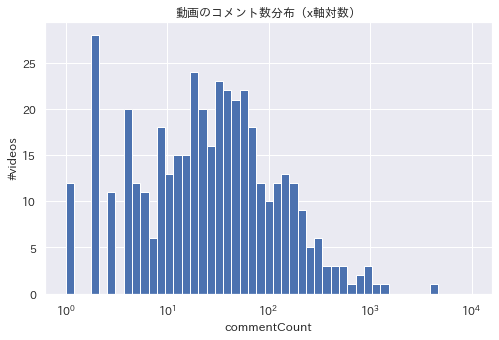

In [515]:
ax=plt.figure(figsize=(8,5)).add_subplot(111)
df.commentCount.dropna().sort_values(ascending=False).hist(bins=np.logspace(0,4,50))
ax.set_xscale('log')
ax.set_xlabel('commentCount')
ax.set_ylabel('#videos')
ax.set_title('動画のコメント数分布（x軸対数）')

### いいね数 と よくないね数 相関

Text(0.5, 1.0, 'いいね数 と よくないね数')

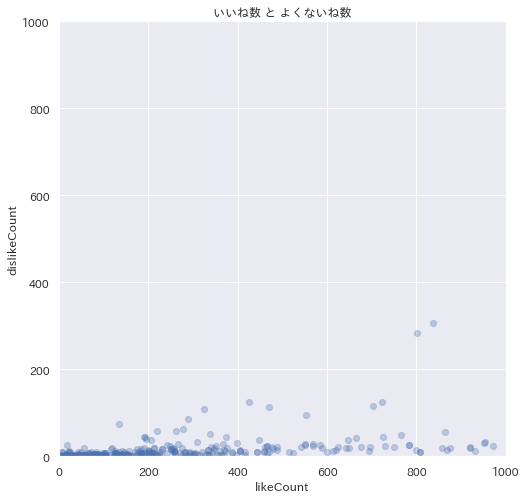

In [516]:
plt.figure(figsize=(8,8))
plt.scatter(x=df.likeCount, y=df.dislikeCount, alpha=0.3)
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.xlabel('likeCount')
plt.ylabel('dislikeCount')
plt.title('いいね数 と よくないね数')

Text(0.5, 1.0, 'いいね数 と よくないね数')

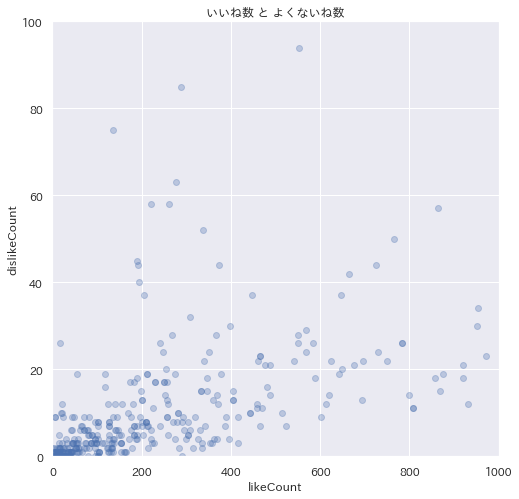

In [517]:
plt.figure(figsize=(8,8))
plt.scatter(x=df.likeCount, y=df.dislikeCount, alpha=0.3)
plt.xlim(0,1000)
plt.ylim(0,100)
plt.xlabel('likeCount')
plt.ylabel('dislikeCount')
plt.title('いいね数 と よくないね数')

### 時期ごとのアップ動画推移

In [518]:
# datetimeからYYYY-MM文字列を生成してこれで集計する
_tmp = pd.DataFrame(df.publishedAt.map(lambda x:x[:7]).value_counts().sort_index())
_tmp.index.name = 'index_YM'

In [519]:
# YYYY-MMの格納先をつくる
published_count_df = pd.DataFrame(columns=['index_YM'])
for y in range(2018, 2021, 1):
    for m in range(1,13, 1):
        index_YM = "%d-%02d" % (y, m)
        published_count_df = published_count_df.append([{
            'index_YM': index_YM
        }])
published_count_df.reset_index(inplace=True, drop=True)

In [520]:
# 格納先に値を入れ込む
published_count_df = published_count_df.merge(
    _tmp,
    how='left',
    on='index_YM'
).fillna(0) # Null値は0埋め
published_count_df.set_index('index_YM')

,publishedAt
index_YM,
2018-01,3.0
2018-02,1.0
2018-03,0.0
2018-04,1.0
2018-05,2.0
2018-06,5.0
2018-07,2.0
2018-08,4.0
2018-09,1.0


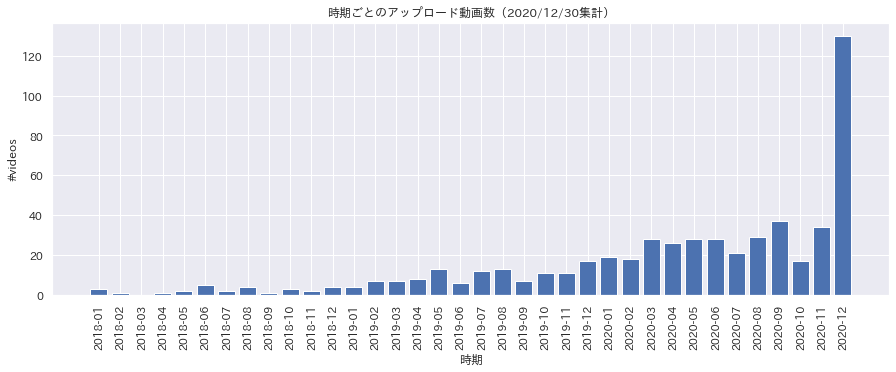

In [521]:
plt.figure(figsize=(15,5))
plt.bar(published_count_df.index_YM, published_count_df.publishedAt)
plt.xticks(rotation=90)
plt.xlabel('時期')
plt.ylabel('#videos')
plt.title('時期ごとのアップロード動画数（2020/12/30集計）')
plt.show()

### タイトル文字数分布

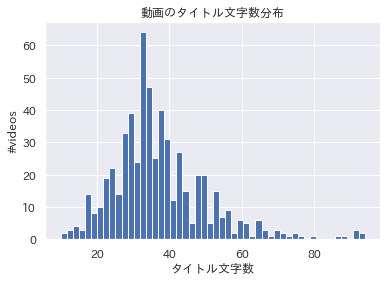

In [522]:
df.title.map(lambda x:len(x)).hist(bins=50)
plt.xlabel('タイトル文字数')
plt.ylabel('#videos')
plt.title('動画のタイトル文字数分布')
plt.show()

### トークン数分布

In [523]:
# stopwordsの取得（英）
import nltk
nltk.download("stopwords")
stop_words = nltk.corpus.stopwords.words("english")

# stopwordsの取得（日）
stop_words += pd.read_table('./data/stop_words_ja.txt', header=None)[0].values.tolist()

# 手で追加
stop_words += ['ため', 'こと', 'よう', 'あなた', '私たち', '我々', '・']

# MeCabによる形態素解析
import MeCab
import sys
import re
m = MeCab.Tagger("-Ochasen -d  /usr/local/lib/mecab/dic/mecab-ipadic-neologd")

# MeCabによる文ごとの形態素解析メソッド 
# - 名詞
# - 2文字以上
# - remove_tokens以外
# - remove_regex以外（正規表現マッチ）
#   * 数値のみ
remove_regex = '(' + '|'.join(['\d+']) + ')'
def split_text_only_noun(text):
    parsed = m.parse(text.replace('\r', ''))
    tokens = [line.split()[0] for line in parsed.splitlines()
              if (\
                  ("名詞" in line.split()[-1]) and \
                  (len(line.split()[0]) >= 2) and \
                  (line.split()[0] not in stop_words) and \
                  (not re.match(remove_regex, line.split()[0]))
                 )
             ][:-1]
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kenshofujisaki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [524]:
# 分かち書きして必要なワードだけ抽出
title_tokens_list = df.title.apply(split_text_only_noun)
print(title_tokens_list[:5])

0             初心者 向け プログラミング 学習
1    プログラミング 講座 プログラミング Akichon
2           堀江 プログラミング 初心者 おすすめ
3           学長 オススメ ロク ラミンク 勉強法
4             会社 プログラミング 独学 なのか
Name: title, dtype: object


max document length:  15


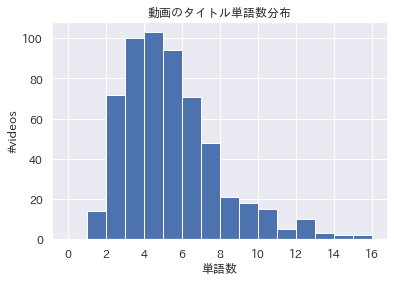

In [525]:
# トークン数の分布確認
def count_tokens(tokenized_text):
    return len(tokenized_text.split(' '))

# トークナイズしてトークン数の集計
doc_length = title_tokens_list.apply(count_tokens)
print('max document length: ', max(doc_length))

# トークン数の分布を可視化
plt.hist(doc_length, bins=range(0, 17, 1))
plt.xlabel("単語数")
plt.ylabel("#videos")
plt.title('動画のタイトル単語数分布')
plt.show()

### トークン分布

<BarContainer object of 100 artists>

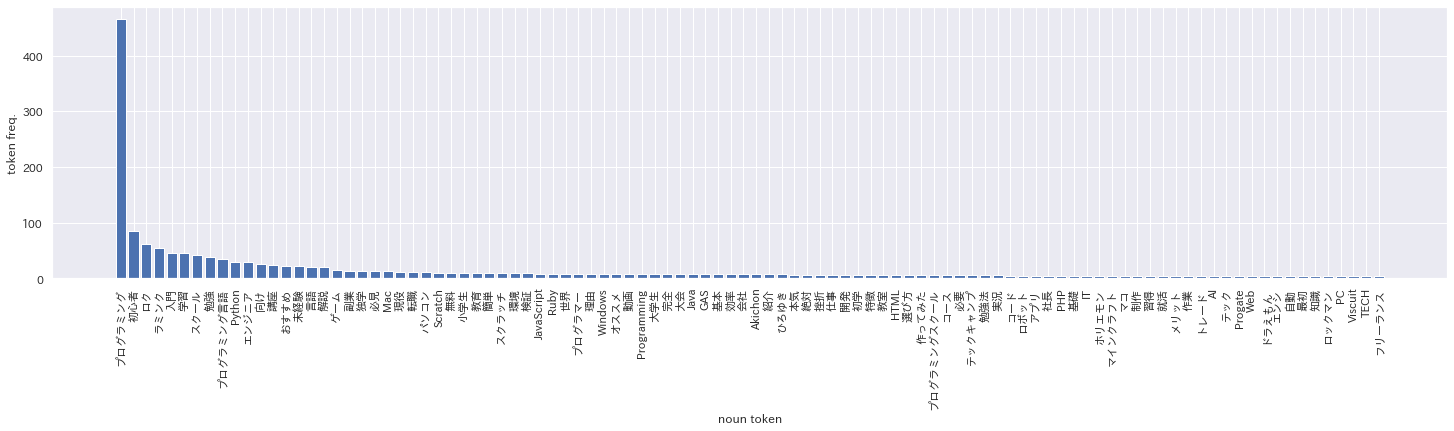

In [526]:
# トークンの分布確認
series_doc_tokens = title_tokens_list.apply(lambda x:str(x).strip().split(' '))
tmp = pd.Series([token for sublist in series_doc_tokens for token in sublist]).value_counts()[:100]
plt.figure(figsize=(25,5))
plt.xticks(rotation=90) # X軸ラベルを90度回転
plt.xlabel("noun token")
plt.ylabel("token freq.")
plt.bar(tmp.index, tmp.values)

## 共起ネットワーク

### networkxによる可視化

In [527]:
import pyfpgrowth
import networkx as nx

# トークンリストから共起ネットワークを可視化
# - token_list: トークンリスト
# - freq_min:   可視化の共起頻度下限値
def vis_cooccurrence(tokens_list, freq_min=20):
    # タグの頻度・共起を算出
    patterns = pyfpgrowth.find_frequent_patterns(
        tokens_list.values.tolist(),
        freq_min # 頻度下限（表示ノード数の制御はここで行う）
    )
    
    # 要素数
    print('要素数: %d' % len(patterns))

    # グラフ生成
    G = nx.Graph()

    # 共起についてのみグラフ化
    for key in patterns.keys():
        if len(key) == 2: # <- 共起の頻度について
            nx.add_path(G, key)

    # ページランクの算出
    pagerank = nx.pagerank(G)

    # ネットワーク描画
    plt.figure(figsize=(20,20))
    nx.draw_networkx(
        G,
        node_color=list(pagerank.values()), # ノードの色をページランクで表現
        cmap=plt.cm.Reds,                   # ノードの色調は赤のグラデーションで
        font_size=15,                       # フォントサイズ
        node_size=100,                      # ノードの大きさ
        font_family='IPAexGothic'           # フォント指定
    )

要素数: 231


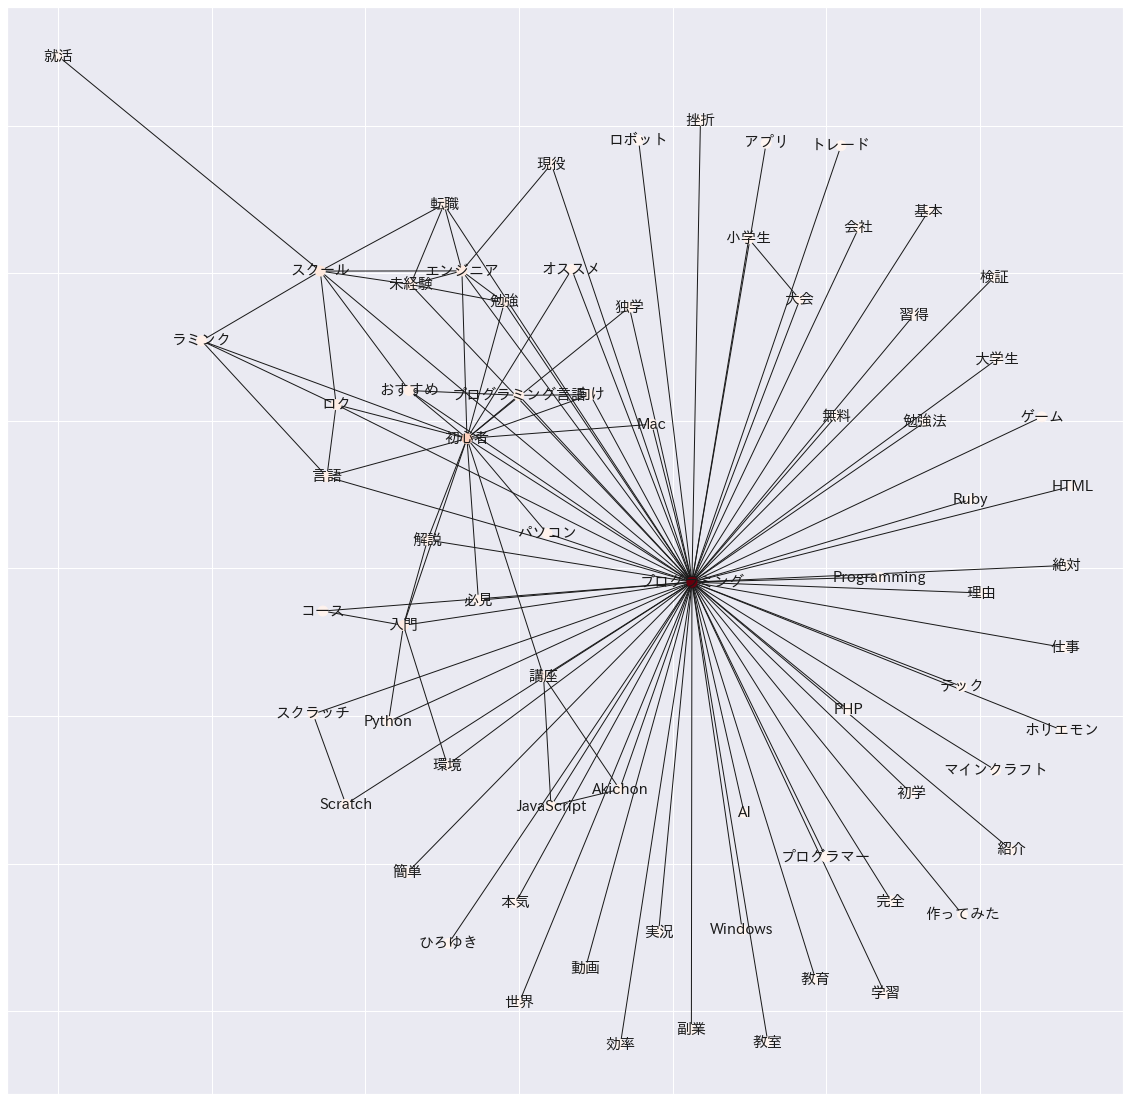

In [528]:
# networkxによる可視化
vis_cooccurrence(
    title_tokens_list.apply(lambda x: x.split(' ')),
    freq_min=5
)

### Gephiによる可視化

- Gephiに入力するためのCSVファイル（nodes.csvとedges.csv）を作成します

In [529]:
# 設定
tokens_list = title_tokens_list.apply(lambda x: x.split(' '))
freq_min = 2 # 頻度下限（表示ノード数の制御はここで行う）

# タグの頻度・共起を算出
patterns = pyfpgrowth.find_frequent_patterns(
    tokens_list.values.tolist(),
    freq_min
)

# 要素数
print('要素数: %d' % len(patterns))

# Gephi向けedges.csv書き出し
with open("./output/%s_gephi_edges.csv" % query, mode='w', encoding='UTF-8') as f:
    f.write("%s;%s;%s\n" % ('Source', 'Target', 'Weight'))
    for key, weight in patterns.items():
        if len(key) == 2: # <- 共起の頻度について
            f.write("%s;%s;%s\n" % (key[0], key[1], weight))

要素数: 5737


In [530]:
# ノード名を取得
key_set = set()
for key in patterns.keys():
    if len(key) == 2: # <- 共起の頻度について
        key_set = key_set | {key[0], key[1]}

# Gephi向けnodes.csv書き出し
pd.DataFrame(
    {'Id': list(key_set), 'Label': list(key_set)}
).to_csv(
    "./output/%s_gephi_nodes.csv" % query,
    index=False
)

- Gephiのファイルを開くから、edges.csvを開き、次にImport spreadsheetからnodes.csvを `Append to existing workspace` として開く
    - そもそもGephiのMacインストールはこちらを参考: https://qiita.com/seisantaro/items/1836e6a192c904b83962
![](./output/機械学習_gephi.svg)
![](./output/プログラミング_gephi.svg)